In [736]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [737]:
import numpy as np
import scipy
import scipy.linalg
from scipy.special import gamma

import plotly.graph_objs as go
import plotly.express as px

In [738]:
def plot_3d_function(f, a = 10, k = 100):
    x = np.linspace(-a, a, k)
    y = x.copy()
    xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    z = f(xy)
    fig = go.Figure(data=[go.Surface(x = x,  y= y, z=z.reshape((x.shape[0], -1)))])
    fig.update_layout(title = f.__name__, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

# Funkcje celu

In [739]:
def sphere_function(X):
    return np.sum(X**2, axis=1)

In [741]:
def ellipsoid_function(X, a=2):
    n = X.shape[-1]
    return np.sum((a**(np.arange(n)/(n-1)))*X**2, axis=1)

In [743]:
def rastrigin_function(X):
    return 10.0 * X.shape[1] + np.sum(X**2, axis=1) - 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [745]:
def schwefel_function(X):
    return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [747]:
def griewank_function(X):
    return 1 + np.sum(X**2 / 4000, axis=1) - np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [749]:
def cigar_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = X[:,0]**2
    x2 = np.sum(a*X[:,1:]**2, axis = 1)
    return x1+x2

In [751]:
def discus_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [753]:
def cigar_discus_function(X, a = 2):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum((a**0.5)*X[:,1:-1]**2, axis = 1)
    x3 = X[:,-1]**2
    return x1+x2+x3

In [755]:
def parab_ridge_function(X):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = - X[:,0]
    x2 = 100*np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [757]:
def two_axes_function(X, a = 5):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    n = X.shape[-1]
    k = n//2
    x1 = np.sum(a*X[:,:k]**2, axis = 1)
    x2 = np.sum(X[:,k:]**2, axis = 1)
    return x1+x2

# Implementacja CMA-ES

In [773]:
class CMA_ES:
    def __init__(self, x0, sigma, maxfevals = 10000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        
        if weights:
            self.weights = weights
        else:
            self.weights = np.array([np.log(self.lam / 2 + 0.5) - np.log(i + 1) if i < self.mu else 0
                        for i in range(self.lam)])
            self.weights /= np.sum(self.weights)
        # self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        self.mueff = 1 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs

        # self.xmean = x0[:]
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps =np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = []   
        self.best = (x0, None)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.ones(N)
        #added by me
        self.learning_rate = 1 #Choosing cm < 1 can be advantageous on noisy functions, σ ∝ 1/cm
        self.time_horizon = 1.5#cc
        self.learning_rate_for_mean = 1 #cm = 1
        self.decay_path = (self.mueff + 2) / (self.dimension + self.mueff + 5) #csigma
        self.dsigma = 1 + 2 * max(0, ((self.mueff - 1) / (self.dimension + 1))**(1/2) - 1) + self.decay_path #dsigma
        self.xmean = np.sum(self.weights[:, np.newaxis] * x0, axis=0)

    def _update_eigensystem(self, current_eval, lazy_gap_evals):
        if current_eval <= self.updated_eval + lazy_gap_evals:
            return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        """Wylosuj prĂłbkÄ nowych osobnikĂłw"""
        # def new_individual():
        #     #self.xmean + self.sigma * N(0, self.C) = self.xmean + self.sigma * (C**1/2 @ N(0, I))
        #     return self.xmean + self.sigma * np.random.multivariate_normal(mean=[0, 0], cov=self.C, size=self.dimension)
        # def new_individual():
        #     return self.xmean + self.sigma * np.random.multivariate_normal(mean=np.zeros(self.dimension), cov=self.C)
        def new_individual():
            scaled_cov = (self.sigma ** 2) * self.C
            return np.random.multivariate_normal(mean=self.xmean, cov=scaled_cov)
    
        return np.array([new_individual() for _ in range(self.lam)])

    def update(self, x, fitvals):
        """Zaktualizuj wartoĹci uzyskanych parametrĂłw"""

        #???
        self._update_eigensystem(np.min(fitvals), self.lazy_gap_evals)
        #??

        self.counteval += fitvals.shape[0] # zwiekszamy licznik wykonan
        N = self.xmean.shape[0]
        xmean_old = self.xmean.copy()
        
        # Posortuj osobniki po wartoĹci funkcji celu
        idx = np.argsort(fitvals)
        x = x[idx]
        self.fitvals = fitvals[idx] #TODO wartosci funkcji celu dla posortowanych osobnikow
        self.best = (x[0], self.fitvals[0])
        
        # self.xmean = (self.weights @ x).ravel()
        self.xmean = self.xmean + self.learning_rate * np.sum(self.weights[:, np.newaxis] * (x - self.xmean), axis=0)
        # Wektor przesuniecia sredniej
        y = (self.xmean - xmean_old) / self.sigma

        # Aktualizacja sciezki ewolucji dla sigmy
        self.ps = (1 - self.decay_path) * self.ps + (self.decay_path * (2 - self.decay_path) * self.mueff)**(1/2) * self.inv_sqrt @ y
 
        # Aktualizacja sciezki ewolucji dla macierzy kowariancji
        self.pc = (1-self.time_horizon)*self.pc + (self.time_horizon*(2-self.time_horizon)*self.mueff)**(1/2) * (self.xmean - xmean_old) / (self.learning_rate_for_mean * self.sigma)  
        
        #Aktualizacja macierzy kowariancji
        self.C = (1-self.c1 - self.cmu * np.sum(self.weights)) * self.C + self.c1 * (self.pc[:, np.newaxis] @ self.pc[np.newaxis, :]) + self.cmu * np.sum(self.weights[:, np.newaxis, np.newaxis] * y * y.T, axis=0)

        self.C = (self.C + self.C.T)/2.0 # Upewniamy siÄ, Ĺźe macierz jest symetryczna
        
        
        # Aktualizacja rozmiaru kroku
        
        self.sigma = self.sigma * np.exp(self.decay_path / self.dsigma * (np.linalg.norm(self.ps) / (np.sqrt(2) * (gamma((self.dimension + 1) / 2) / gamma(self.dimension / 2))) - 1))
        
    def terminate(self):
        """ZakoĹcz algorytm"""
        if self.counteval <= 0:
            return False
        if self.counteval >= self.maxfevals:
            return True
        if self.condition_number > 1e13:
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            return True
        return False

In [760]:
def optimize(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    cntr = 0
    while not cma_es.terminate():
        cntr+=1
        x = cma_es.sample()
        f_eval = func(x)
        cma_es.update(x, f_eval)
        res.append(cma_es.best)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res

In [797]:
def optimize_and_plot(f, sigma = 1, d = 10, popsize = None):
    x0 = np.repeat(100.0, d)
    res = optimize(f, x0, sigma, popsize = popsize)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])
    fig = px.line(x = np.arange(y.shape[0]) + 1, y = y)
    fig.show()

In [889]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def optimize(func, x0, sigma, maxfevals=1000, popsize=None, weights=None):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    xes = []
    cntr = 0
    while not cma_es.terminate():
        cntr += 1
        x = cma_es.sample()
        f_eval = func(x)
        cma_es.update(x, f_eval)
        res.append(cma_es.best)
        xes.append(x)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res, xes

# Function to draw the ellipse representing the 95% probability contour
def plot_ellipse(mean, cov_matrix, ax, color='red', alpha=0.2, label=None):
    eigvals, eigvecs = np.linalg.eig(cov_matrix)
    order = eigvals.argsort()[::-1]  # Sort by eigenvalue, largest first
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(*eigvecs[:, 0][::-1])
    angle = np.degrees(angle)
    if angle < 0:
        angle += 180
    
    # 95% confidence interval ellipse
    v = 2.45  # 95% confidence for 2D normal distribution
    width, height = 2 * v * np.sqrt(eigvals)
    # ellipse = Ellipse(mean, width, height, angle, color=color, alpha=alpha, label=label)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=alpha, label=label)
   
    ax.add_patch(ellipse)
    buffer = 10  # Extra space around the ellipse
    ax.set_xlim(mean[0] - (width / 2 + buffer), mean[0] + (width / 2 + buffer))
    ax.set_ylim(mean[1] - (height / 2 + buffer), mean[1] + (height / 2 + buffer))

def optimize_and_plot(f, sigma=1, d=2, popsize=None):
    x0 = np.repeat(100.0, d)
    res, xes = optimize(f, x0, sigma, popsize=popsize)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])
    # fig = px.line(x = np.arange(y.shape[0]) + 1, y = y)
    # fig.show()

    for i in range(5):
        fig, ax = plt.subplots(figsize=(10, 10))
        this_gen = xes[i]
        next_gen = xes[i + 1]

        common_points = np.array(list(set([tuple(x) for x in this_gen]) & set([tuple(x) for x in next_gen])))
        print(common_points)
        #plot indivuduals in common_points - those who made it to next gen:
        dead = np.array([])
        if(common_points.size > 0):
            ax.scatter(common_points[:, 0], common_points[:, 1], color='blue', label='Survivors')
            dead = np.array([x for x in this_gen if tuple(x) not in common_points])
        #plot individuals in this_gen but not in next_gen - those who died (this_gen - common_points)
        if(dead.size > 0):
            ax.scatter(dead[:, 0], dead[:, 1], color='black', label='Dead')
        #plot the ellipse equivalent to 95% probability of N(self.xmean, self.C)
        mean_this_gen = np.mean(this_gen, axis=0)
        cov_this_gen = np.cov(this_gen.T)
        plot_ellipse(mean_this_gen, cov_this_gen, ax, color='red', alpha=0.2, label='Generation g')
        #plot the ellipse equivalent to 95% probability of N(self.xmean, self.C) for next_gen
        mean_next_gen = np.mean(next_gen, axis=0)
        cov_next_gen = np.cov(next_gen.T)
        plot_ellipse(mean_next_gen, cov_next_gen, ax, color='green', alpha=0.2, label='Generation g+1')
        plt.show()
        plt.clf()

Popsize: 6
Iteration   100: 3.9798311905549113
Best: [-1.98991221e+00 -4.57465316e-08], value: 3.979831190554588
[]


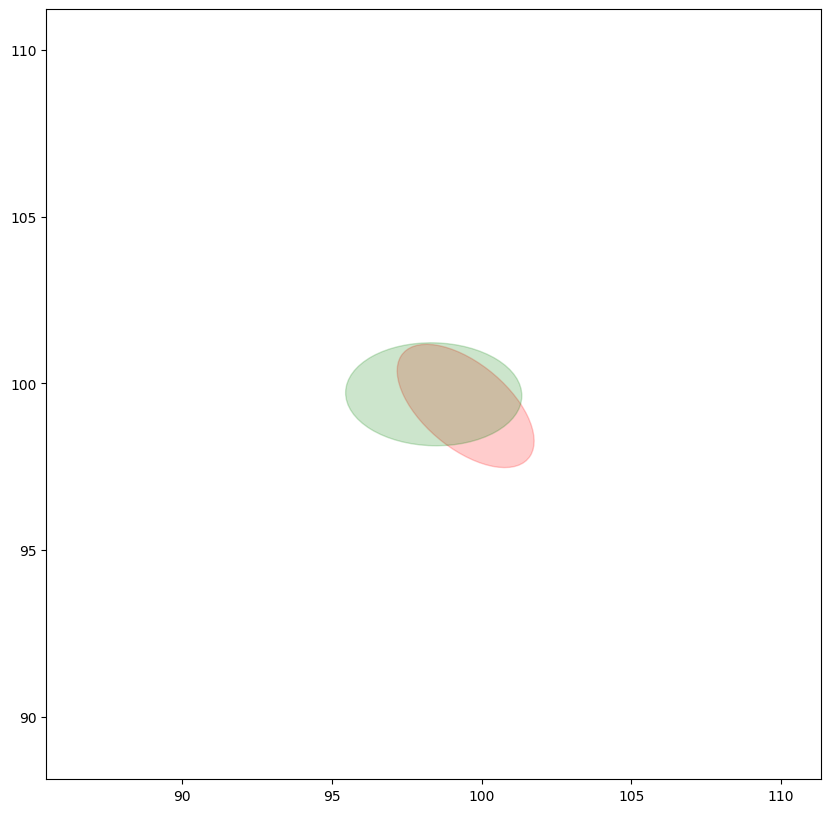

[]


<Figure size 640x480 with 0 Axes>

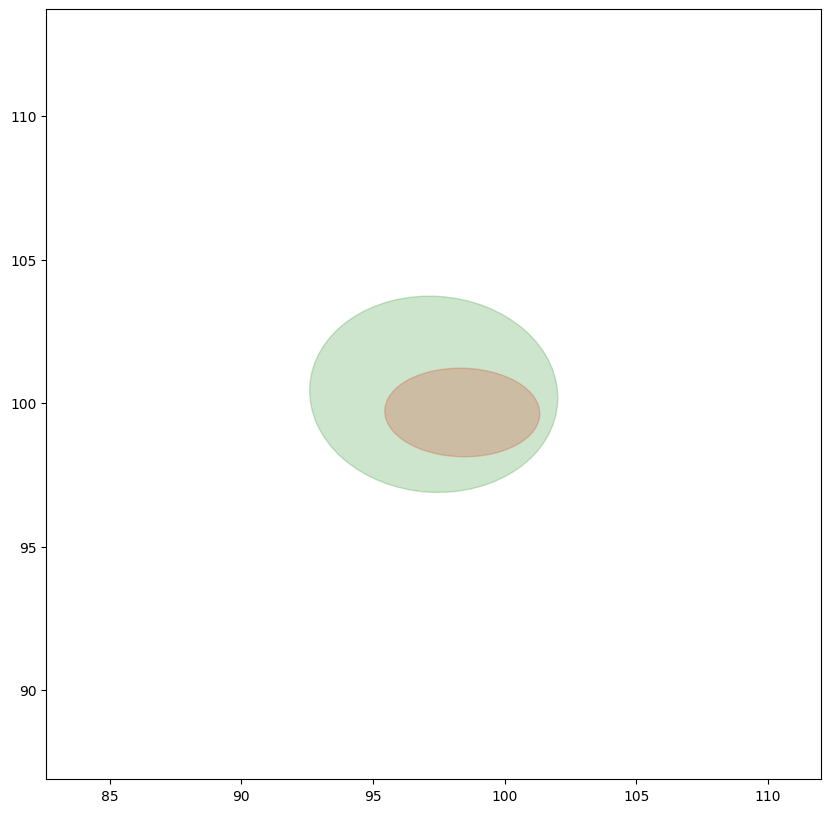

[]


<Figure size 640x480 with 0 Axes>

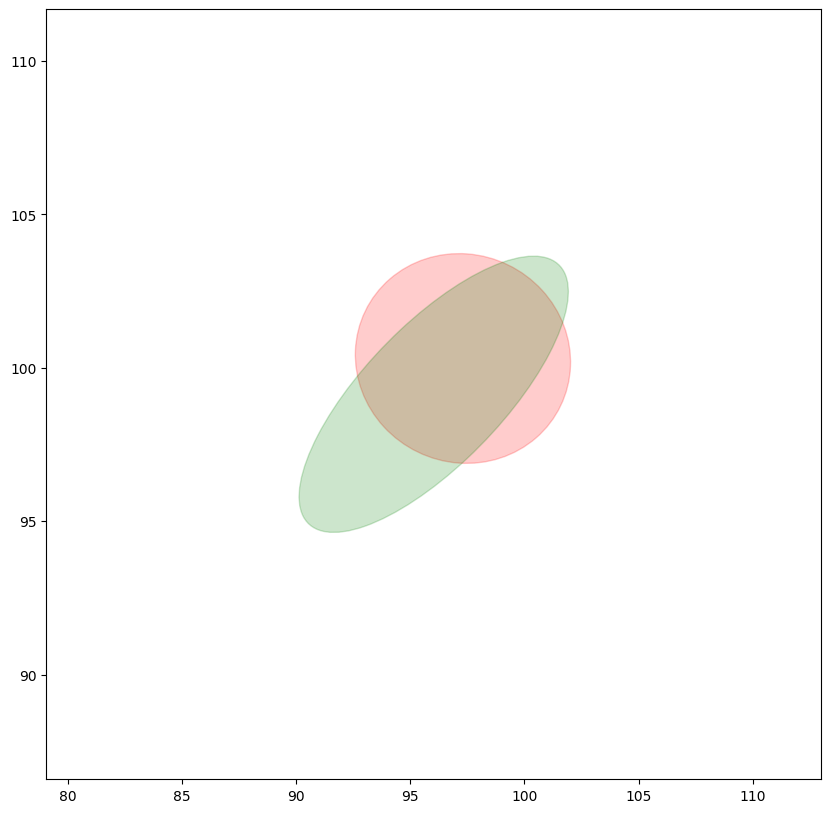

[]


<Figure size 640x480 with 0 Axes>

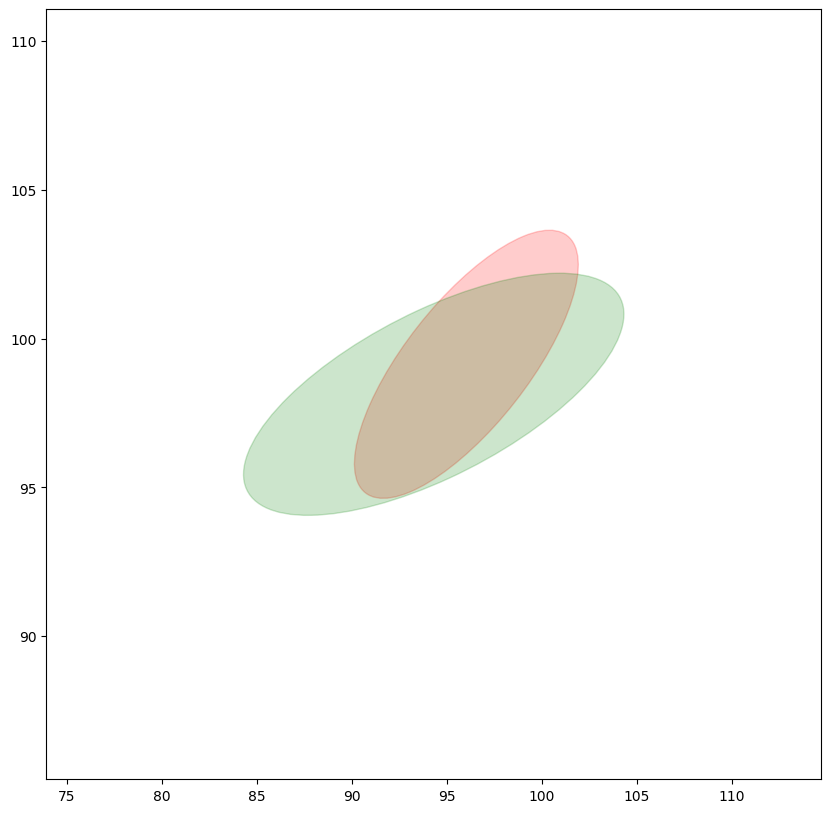

[]


<Figure size 640x480 with 0 Axes>

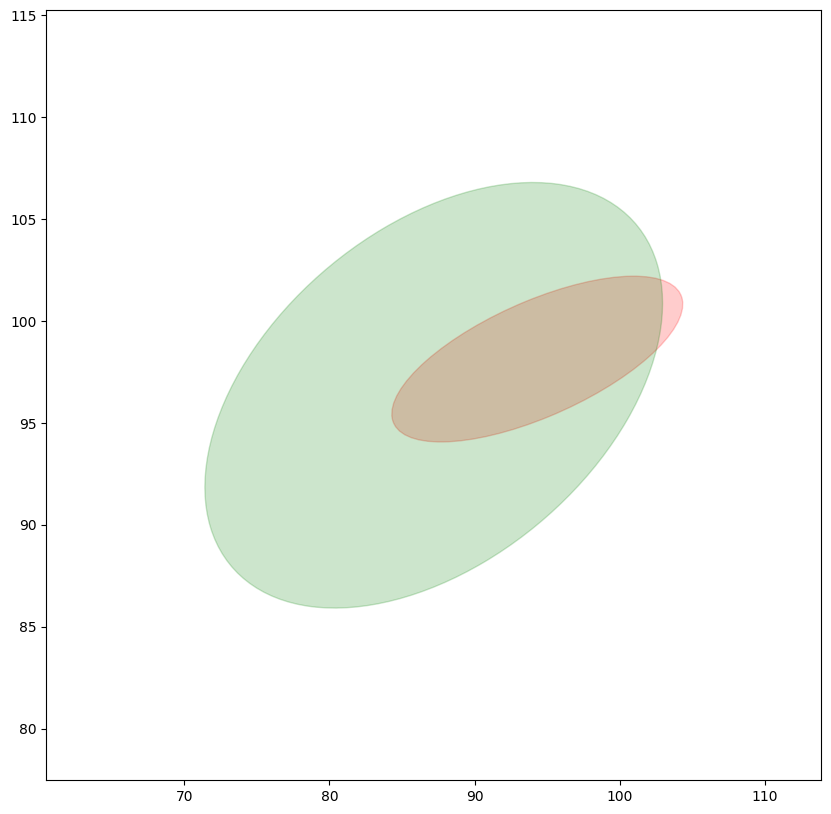

<Figure size 640x480 with 0 Axes>

In [890]:
optimize_and_plot(rastrigin_function)

# Ewaluacja CMA-ES

In [762]:
optimize_and_plot(sphere_function, d = 2)

Popsize: 6
Iteration   100: 4.118820902019922e-17
Best: [ 3.26104204e-18 -3.67927341e-18], value: 2.4171448078247327e-35


In [763]:
optimize_and_plot(sphere_function, sigma = 200)

Popsize: 10
Iteration   100: 0.07744382876051258
Best: [-0.17362498  0.11530984  0.09140424  0.09351762 -0.01470269 -0.0044685
  0.02694183 -0.09635968  0.03191     0.0750741 ], value: 0.07744382876051258


In [764]:
optimize_and_plot(sphere_function)

Popsize: 10
Iteration   100: 1.0575844055822852
Best: [-0.14931628 -0.16943483 -0.12866337  0.17578934  0.28691348  0.21684617
  0.41295081 -0.43552873  0.07343194  0.68130553], value: 1.0575844055822852


In [765]:
optimize_and_plot(ellipsoid_function)

Popsize: 10
Iteration   100: 1.0507792192754963
Best: [-0.77161825  0.37199854 -0.22663342  0.18975046  0.1320881  -0.32656375
 -0.07672612  0.02077437 -0.00485353 -0.07083132], value: 1.0507792192754963


In [766]:
optimize_and_plot(griewank_function)

Popsize: 10
Iteration   100: 0.14616366899096456
Best: [ 6.26920749  4.57889611  5.40586052  6.53728661  0.53910979  0.1738525
 -0.28114853  8.30179722 -0.71250451 -0.02763635], value: 0.14616366899096456


Popsize: 6
Iteration   100: 0.9949590570949098
Best: [-9.94958638e-01  1.75139561e-10], value: 0.9949590570932898
[99.02788582 98.84259618]


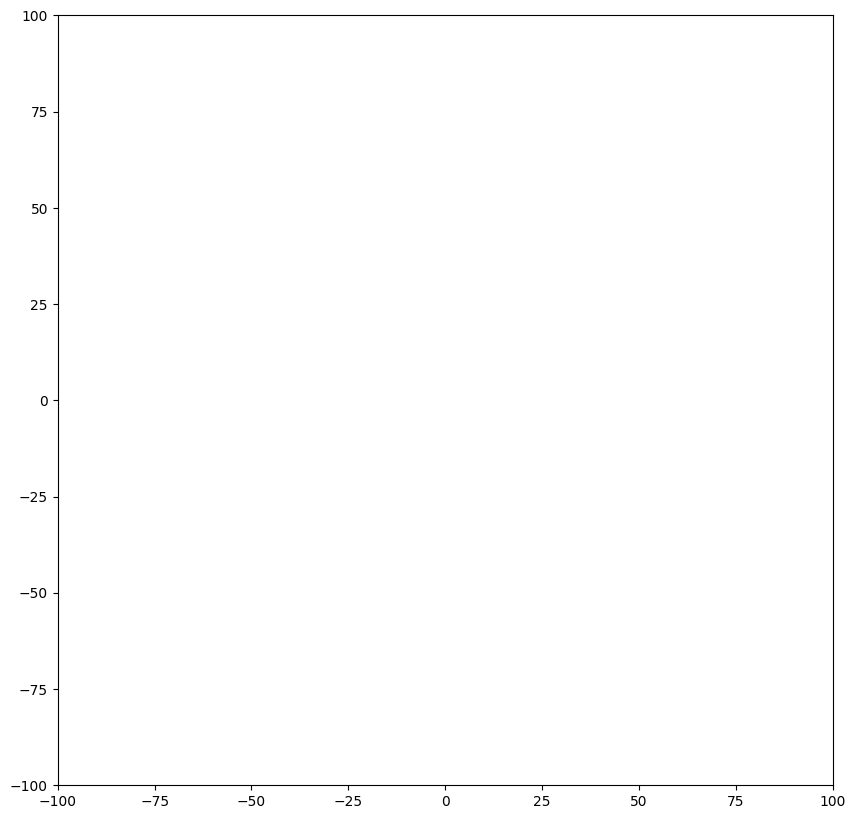

In [ ]:
optimize_and_plot(rastrigin_function)

Zadanie c

Popsize: 6
Iteration   100: 3.268496584496461e-13
Best: [-4.00688710e-10 -1.96940497e-09], value: 0.0


AttributeError: 'list' object has no attribute 'shape'

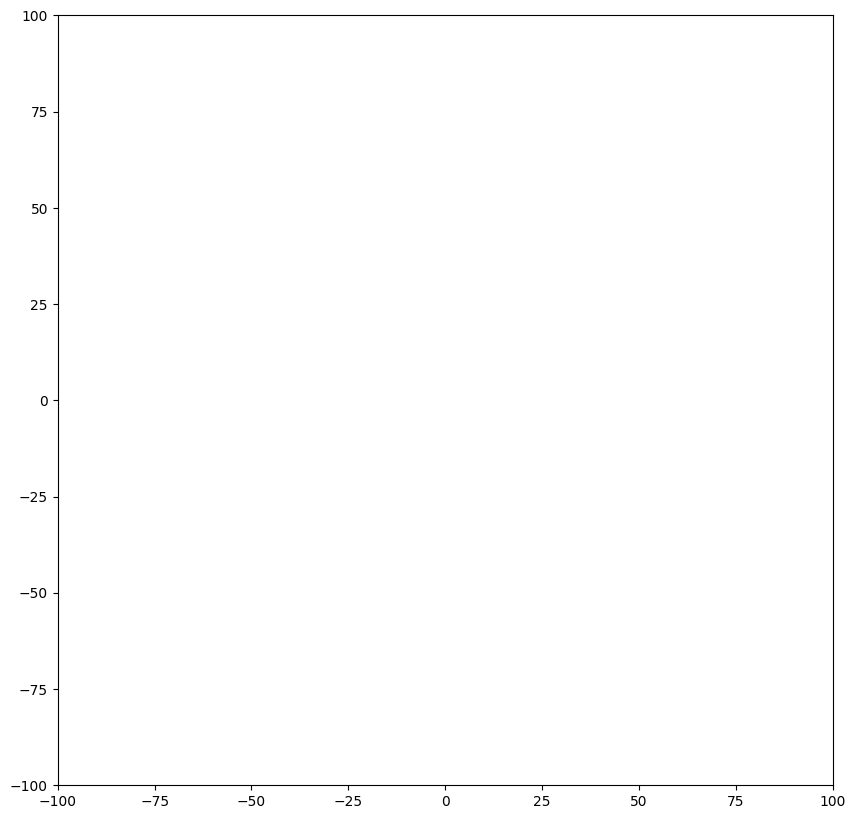

In [825]:
optimize_and_plot(rastrigin_function)